In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
import numpy as np
import random
import copy
from tqdm import tqdm
from collections import deque

/home/ec2-user/.local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

False

In [13]:
#environment class
class Environment():
    
    #initialize dataset, a random trajectory, and current cycle
    def __init__(self):
        self.dataset = pd.read_csv('train.csv')
        self.episode = self.get_trajectory(np.random.randint(low=1, high=79, size=1))
        self.cycle = 0
        self.account = 100
        
    #get random trajectory
    def get_trajectory(self, engine_id):
        return self.dataset[self.dataset.engine_id==engine_id.item()].health_indicator.to_numpy()
    
    #reset environment    
    def reset(self):
        self.cycle = 0
        self.episode = self.get_trajectory(np.random.randint(low=0, high=79, size=1))
        
    #return current state
    def get_state(self):
        return torch.tensor([self.episode[self.cycle], self.account], requires_grad=False)
    
    #take action
    def take_action(self, action):
        #hold 
        if action == 0:
            #failure occurs, return -250 and terminate episode
            if self.cycle+1 == self.episode.size:
                self.account+=-300
                res = (None, -300, True)
            #continued operation, return 1 and continue episode
            else:
                self.account+=1
                res = (np.array([self.episode[self.cycle+1], self.account]), 1, False)
            #move to next state
            self.cycle+=1
            return res
        #replace
        elif action == 1:
            #replace engine if account has enough
            if self.account >= 150:
                self.account+=-150
                self.cycle = 0
                res = (np.array([self.episode[self.cycle], self.account]), -150, False)
                return res
            #bankrupcy, terminate episode after next state
            else:
                #return if next state is engine failure
                if self.cycle+1 == self.episode.size:
                    self.account+=-250
                    res = (None, -250, True)
                    return res
                #return if next state is continued operation 
                else:
                    return self.take_action(0)

In [14]:
class Transition():
    
    def __init__(self, state, action, state_new, reward):
        self.state = state
        self.action = action
        self.state_new = state_new
        self.reward = reward
        
class ReplayMemory():

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [15]:
#dqn model clas 
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.lin1 = nn.Linear(2,10)
        self.lin2 = nn.Linear(10,2)

    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        return x

In [16]:
def get_action(net, state, epsilon):
    with torch.no_grad():
        greedy = np.random.choice([True, False], p=[1-epsilon, epsilon])
        if greedy:
            action = torch.argmax(state, dim=0).item()
        else:
            action = random.choice([0,1])
        return action

In [17]:
class Agent():
    
    def __init__(self):
        
        #hyperparameters
        self.exp_replay_size = 256
        self.gamma = 0.99
        self.epsilon = 0.1
        self.target_update_steps = 5
        self.num_episodes = 10000
        self.batch_size = 64
        self.train_step_count = 128
        self.train_count = 0
        self.steps = 0
        self.loss_func = nn.HuberLoss()
        
        #networks
        self.QNet = DQN()
        self.TNet = DQN()
        self.optimizer = torch.optim.RMSprop(self.QNet.parameters())
        
        #replay buffer
        self.ER = ReplayMemory(self.exp_replay_size)

In [18]:
def optimize(agent):
    
    sample_transitions = agent.ER.sample(agent.batch_size)
    
    #increment train counter
    agent.train_count +=1
    
    #copy weights to target network after every 'target_update_steps' updates
    if agent.train_count == agent.target_update_steps:
        agent.train_count = 0
        agent.TNet = copy.deepcopy(agent.QNet)
        
    #calculate q-values and expected values
    qp = agent.QNet(Variable(torch.tensor([transition.state.numpy() for transition in sample_transitions]).float()))
    qp = torch.max(qp, dim=1).values
    qn = agent.TNet(Variable(torch.tensor([transition.state_new for transition in sample_transitions]).float()))
    qn = torch.max(qn, dim=1).values
    qn = qn + torch.tensor([transition.reward for transition in sample_transitions])
    qn = agent.gamma * qn
    
    return agent.loss_func(qp, qn)

In [20]:
agent = Agent()
agent.QNet.train()
losses = []
cummulative_rewards = []

for episode in tqdm(range(agent.num_episodes)):
    
    environment = Environment()
    cummulative_reward = 0

    while True:
        
        #observation
        state = environment.get_state()
        action = get_action(agent.QNet, state, agent.epsilon)
        state_new, reward, terminated = environment.take_action(action)
        #append to replay buffer
        agent.ER.push(state, action, state_new, reward)

        #update variables
        cummulative_reward+=reward
        
        print("State: {}, Action: {}, Reward: {}, New State: {}, Cummulative Reward: {}".format(state.numpy().tolist(), action, reward, state_new, cummulative_reward))
        
        #increament step count
        agent.steps+=1
        
        #train after every 'train_step_count' steps
        if agent.steps==agent.train_step_count:
            agent.steps = 0
            agent.epsilon *= 0.99
            agent.optimizer.zero_grad()
            loss = optimize(agent)
            loss.backward()
            agent.optimizer.step()
            losses.append(loss.item())
        
        #break when episode is complete
        if terminated:
            break
    
    cummulative_rewards.append(cummulative_reward)

  0%|                                                                                               | 0/10000 [00:00<?, ?it/s]

State: [0.302257212354948, 100.0], Action: 1, Reward: 1, New State: [  0.35206258 101.        ], Cummulative Reward: 1
State: [0.3520625821060019, 101.0], Action: 1, Reward: 1, New State: [  0.30400942 102.        ], Cummulative Reward: 2
State: [0.3040094157986424, 102.0], Action: 1, Reward: 1, New State: [  0.32541294 103.        ], Cummulative Reward: 3
State: [0.3254129402585349, 103.0], Action: 1, Reward: 1, New State: [  0.28354728 104.        ], Cummulative Reward: 4
State: [0.2835472780285812, 104.0], Action: 1, Reward: 1, New State: [  0.3251887 105.       ], Cummulative Reward: 5
State: [0.3251887030646041, 105.0], Action: 1, Reward: 1, New State: [  0.28943008 106.        ], Cummulative Reward: 6
State: [0.2894300782538229, 106.0], Action: 1, Reward: 1, New State: [  0.36653099 107.        ], Cummulative Reward: 7
State: [0.3665309932367787, 107.0], Action: 1, Reward: 1, New State: [  0.25454556 108.        ], Cummulative Reward: 8
State: [0.2545455597381217, 108.0], Action:

  0%|                                                                                               | 0/10000 [00:05<?, ?it/s]

State: [0.3176179704316632, 12.0], Action: 1, Reward: 1, New State: [ 0.33948958 13.        ], Cummulative Reward: -87
State: [0.3394895817799294, 13.0], Action: 1, Reward: 1, New State: [ 0.3299428 14.       ], Cummulative Reward: -86
State: [0.3299427975204427, 14.0], Action: 1, Reward: 1, New State: [ 0.26079786 15.        ], Cummulative Reward: -85
State: [0.2607978590720995, 15.0], Action: 1, Reward: 1, New State: [ 0.37571427 16.        ], Cummulative Reward: -84
State: [0.3757142730466706, 16.0], Action: 1, Reward: 1, New State: [ 0.35414052 17.        ], Cummulative Reward: -83
State: [0.3541405205740749, 17.0], Action: 1, Reward: 1, New State: [ 0.26686766 18.        ], Cummulative Reward: -82
State: [0.2668676577118775, 18.0], Action: 1, Reward: 1, New State: [ 0.26593594 19.        ], Cummulative Reward: -81
State: [0.2659359357737665, 19.0], Action: 1, Reward: 1, New State: [ 0.30592176 20.        ], Cummulative Reward: -80
State: [0.3059217600913932, 20.0], Action: 1, Rewa

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
plt.plot((np.convolve(losses, np.ones(5), 'valid') / 5), label='hubor loss')
plt.legend()
plt.show()

In [ ]:
agent.QNet.eval()
environment = Environment()
cummulative_rewards = []
cummulative_reward = 0
while True:

    #observation
    state = environment.get_state()
    action = get_action(agent.QNet, state, epsilon=0)
    state_new, reward, terminated = environment.take_action(action)
    
    #update variables
    cummulative_reward+=reward
    
    print("State: {}, Action: {}, Reward: {}, New State: {}, Cummulative Reward: {}".format(state.numpy().tolist(), action, reward, state_new, cummulative_reward))

    #break when episode is complete
    if terminated:
        break

    cummulative_rewards.append(cummulative_reward)

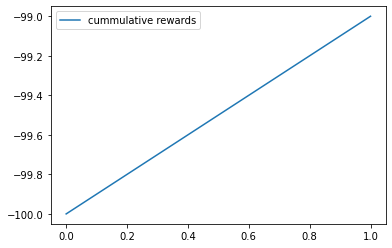

In [12]:
plt.plot(cummulative_rewards, label='cummulative rewards')
plt.legend()
plt.show()